In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pulp

In [2]:
curve = [
    "Apr'21", 2.921,
    "May'21", 2.892,
    "Jun'21", 2.922,
    "Jul'21", 2.96,
    "Aug'21", 2.974,
    "Sep'21", 2.966,
    "Oct'21", 3.007,
    "Nov'21", 3.07,
    "Dec'21", 3.203,
    "Jan'22", 3.294,
    "Feb'22", 3.216,
    "Mar'22", 3.03,
    "Apr'22", 2.568,
    "May'22", 2.48,
    "Jun'22", 2.525,
    "Jul'22", 2.562,
    "Aug'22", 2.57,
    "Sep'22", 2.559,
    "Oct'22", 2.592,
    "Nov'22", 2.681,
    "Dec'22", 2.87,
    "Jan'23", 2.987,
    "Feb'23", 2.939,
    "Mar'23", 2.779,
    "Apr'23", 2.388
]

In [3]:
df = pd.DataFrame( data={ 'Contract': curve[0::2], 'Price': curve[1::2]})

<AxesSubplot:xlabel='Contract'>

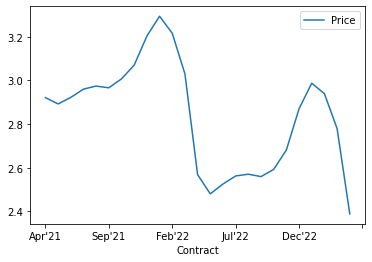

In [4]:
df.plot(x='Contract', y='Price')

In [23]:
N=3 # number of months to use
max_storage_capacity=100000
max_daily_injection=pd.DataFrame(data=[(-0.01,8000),(0.5,8000),(1.01,8000)], columns=['ratchet', 'mdiq'] )
max_daily_withdrawal=pd.DataFrame( data=[(-0.01,9000),(0.5,9000),(1.01,9000)], columns=['ratchet', 'mdwq'] )

<AxesSubplot:xlabel='ratchet'>

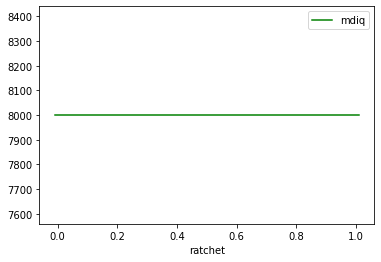

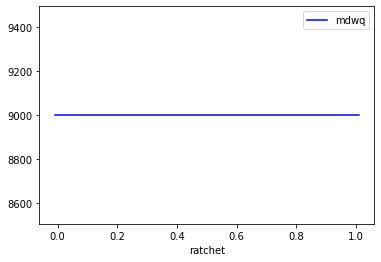

In [24]:
max_daily_injection.plot(x='ratchet',y='mdiq', style='g-', )
max_daily_withdrawal.plot(x='ratchet',y='mdwq',style='b-')

In [25]:
# injection / withdrawal quantities
I=[None]*N
W=[None]*N
for i in range(N):
    I[i] = pulp.LpVariable(f'I_{i}', lowBound=0, cat='Integer')
    W[i] = pulp.LpVariable(f'W_{i}', lowBound=0, cat='Integer')

In [26]:
# number of days in each injection / drawing month
days = list( map( lambda x: ((x+pd.DateOffset(months=1))-x).days, df.Contract.apply( lambda x: pd.to_datetime( '1-' + x ))))
days[0] = 2
days[1] = 2
days[2] = 2

# number of calendar days in the simulation
M = sum( days[0:N])

prices = list(df.Price)

In [27]:
injection_charges=[None]*N
total_injection=[None]*N
daily_injection=[None]*M

# for each injection month
for i in range(N):
    total_injection[i] = I[i]*10000
    injection_charges[i] = -total_injection[i] * prices[i]
    
for i in range(N):
    lb = sum(days[0:i])
    ub = sum(days[:i+1])
    daily_injection[lb:ub] = [ total_injection[i] / days[i] ] * days[i]

withdrawal_credit=[None]*N
total_draw=[None]*N
daily_draw=[None]*M

# for each drawing month
for j in range(N):
    total_draw[j] = W[j]*10000
    withdrawal_credit[j] = total_draw[j] * prices[j]
    
for i in range(N):
    lb = sum(days[0:i])
    ub = sum(days[:i+1])
    daily_draw[lb:ub]  = [ total_draw[i] / days[i] ] * days[i]

daily_storage=[None]*M
for i in range(M):
    if i == 0:
        daily_storage[i] = daily_injection[i] - daily_draw[i]
    else:
        daily_storage[i] = daily_injection[i] - daily_draw[i] + daily_storage[i-1]

In [28]:
# ratchet range control variables 
injection_range = [[None] * 2 for _ in range(M-1)]
withdrawal_range = [[None] * 2 for _ in range(M-1)]

for i in range(0,M-1):
    for j in range(max_daily_injection.shape[0]-1):
        injection_range[i][j] = pulp.LpVariable(f'ic_{i+1}_{j}', cat='Binary')

    for j in range(max_daily_withdrawal.shape[0]-1):
        withdrawal_range[i][j] = pulp.LpVariable(f'wc_{i+1}_{j}', cat='Binary')

In [101]:
m = pulp.LpProblem("WithRatchetsDaily", pulp.LpMaximize)

# target function
m += pulp.lpSum(withdrawal_credit) + pulp.lpSum(injection_charges)

# add constraints
for i in range(M):
    m += daily_storage[i] >= 0
    m += daily_storage[i] <= max_storage_capacity

# storage is empty on day 0
m += daily_injection[0] <= max_daily_injection.loc[0, 'mdiq']
m += daily_draw[0] <= max_daily_withdrawal.loc[ 0, 'mdwq']

# ratchet control
for i in range(M-1):

    # injection
    # only one range is allowed
    m += pulp.lpSum( injection_range[i] ) == 1

    # first range
    m += injection_range[i][0] * max_daily_injection.loc[0,'ratchet'] <=  daily_storage[i] / max_storage_capacity
    m += injection_range[i][0] * max_daily_injection.loc[1,'ratchet'] >=  daily_storage[i] / max_storage_capacity

    # second range
    m += injection_range[i][1] * max_daily_injection.loc[1,'ratchet'] <=  daily_storage[i] / max_storage_capacity
    if i == 1:
        m += injection_range[i][1] * max_daily_injection.loc[2,'ratchet'] >=  daily_storage[i] / max_storage_capacity
    
    # daily rate constraint
#    m += daily_injection[i+1] <= injection_range[i][0] * max_daily_injection.loc[1,'mdiq'] + \
#        injection_range[i][1] * max_daily_injection.loc[2,'mdiq']
    
    # withdrawal
    # only one range is allowed
#    m += pulp.lpSum( withdrawal_range[i] ) == 1

    # first range
#    m += withdrawal_range[i][0] * max_daily_withdrawal.loc[0,'ratchet'] <=  daily_storage[i] / max_storage_capacity
#    m += daily_storage[i] / max_storage_capacity <= withdrawal_range[i][0] * max_daily_withdrawal.loc[1,'ratchet']

    # second range
#    m += withdrawal_range[i][1] * max_daily_withdrawal.loc[1,'ratchet'] <=  daily_storage[i] / max_storage_capacity
#    m += daily_storage[i] / max_storage_capacity <= withdrawal_range[i][1] * max_daily_withdrawal.loc[2,'ratchet']
    
    # daily rate constraint
#    m += daily_draw[i+1] <= withdrawal_range[i][0] * max_daily_withdrawal.loc[1,'mdwq'] + \
#        withdrawal_range[i][1] * max_daily_withdrawal.loc[2,'mdwq']

    m += daily_injection[i+1] <= max_daily_injection.loc[0, 'mdiq']
    m += daily_draw[i+1] <= max_daily_withdrawal.loc[ 0, 'mdwq']


# ensure that storage on last day is empty
m += daily_storage[M-1] == 0

In [102]:
pulp.listSolvers(onlyAvailable=True)

['PULP_CBC_CMD', 'PULP_CHOCO_CMD']

In [103]:
solver = pulp.getSolver('PULP_CHOCO_CMD')
m.solve(solver)
pulp.LpStatus[m.status]

'Optimal'

In [104]:
print( pulp.value(m.objective) )

300.0


In [105]:
for variable in m.variables():
#    if variable.varValue != 0.0:
        print( "{} = {}".format(variable.name, variable.varValue) )

I_0 = 0.0
I_1 = 1.0
I_2 = 0.0
W_0 = 0.0
W_1 = 0.0
W_2 = 1.0
ic_1_0 = 1.0
ic_1_1 = 0.0
ic_2_0 = 1.0
ic_2_1 = 0.0
ic_3_0 = 1.0
ic_3_1 = 0.0
ic_4_0 = 1.0
ic_4_1 = 0.0
ic_5_0 = 1.0
ic_5_1 = 0.0


In [100]:
df_result = pd.DataFrame( data={
    'gas_in_storage': map(lambda x: pulp.value(x) / max_storage_capacity, daily_storage),
    'daily_injection': map(lambda x: pulp.value(x), daily_injection),
    'daily_draw': map(lambda x: pulp.value(x), daily_draw),
})


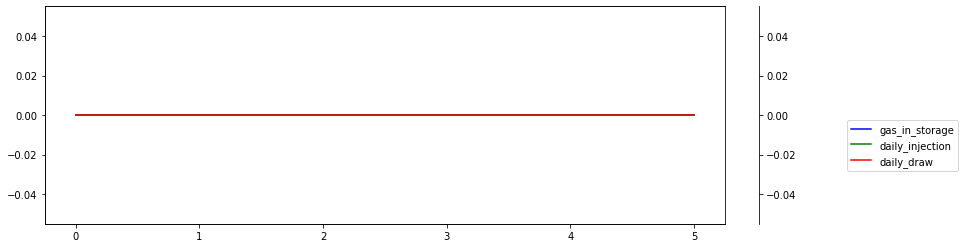

In [57]:
fig, ax = plt.subplots()
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=1.7)

df_result['gas_in_storage'].plot(ax=ax, style='b-')
df_result['daily_injection'].plot(ax=ax3, style='g-')
df_result['daily_draw'].plot(ax=ax3, style='r-')

ax3.legend([ax.get_lines()[0], ax3.get_lines()[0], ax3.get_lines()[1]], ['gas_in_storage','daily_injection', 'daily_draw'], bbox_to_anchor=(1.35, 0.5))

In [17]:
list(map(lambda x: pulp.value(x) / max_storage_capacity, daily_storage))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [18]:
pulp.value(injection_range[0][0]) + pulp.value(injection_range[0][1])

1.0

In [19]:
max_daily_injection.loc[1,'ratchet']

0.5

In [20]:
[ (pulp.value( injection_range[i][0]) * max_daily_injection.loc[1,'ratchet'] - pulp.value(daily_storage[i]) / max_storage_capacity) for i in range(M-1)]

[0.5, 0.5, 0.5, 0.5, 0.5]

In [33]:
m

WithRatchetsDaily:
MAXIMIZE
-29210.0*I_0 + -28920.0*I_1 + -29220.0*I_2 + 29210.0*W_0 + 28920.0*W_1 + 29220.0*W_2 + 0.0
SUBJECT TO
_C1: 5000 I_0 - 5000 W_0 >= 0

_C2: 5000 I_0 - 5000 W_0 <= 100000

_C3: 10000 I_0 - 10000 W_0 >= 0

_C4: 10000 I_0 - 10000 W_0 <= 100000

_C5: 10000 I_0 + 5000 I_1 - 10000 W_0 - 5000 W_1 >= 0

_C6: 10000 I_0 + 5000 I_1 - 10000 W_0 - 5000 W_1 <= 100000

_C7: 10000 I_0 + 10000 I_1 - 10000 W_0 - 10000 W_1 >= 0

_C8: 10000 I_0 + 10000 I_1 - 10000 W_0 - 10000 W_1 <= 100000

_C9: 10000 I_0 + 10000 I_1 + 5000 I_2 - 10000 W_0 - 10000 W_1 - 5000 W_2 >= 0

_C10: 10000 I_0 + 10000 I_1 + 5000 I_2 - 10000 W_0 - 10000 W_1 - 5000 W_2
 <= 100000

_C11: 10000 I_0 + 10000 I_1 + 10000 I_2 - 10000 W_0 - 10000 W_1 - 10000 W_2
 >= 0

_C12: 10000 I_0 + 10000 I_1 + 10000 I_2 - 10000 W_0 - 10000 W_1 - 10000 W_2
 <= 100000

_C13: 5000 I_0 <= 8000

_C14: 5000 W_0 <= 9000

_C15: ic_1_0 + ic_1_1 = 1

_C16: - 0.05 I_0 + 0.05 W_0 - 0.01 ic_1_0 <= 0

_C17: - 0.05 I_0 + 0.05 W_0 + 0.5 ic_1_

In [22]:
M

6

In [50]:
max_daily_injection.loc[1,'ratchet']

0.5

In [51]:
max_daily_injection.loc[2,'ratchet']

1.01